In [834]:
# import libraries

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10, 6)})

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [835]:
# import dataset from seaborn library

df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [836]:
# check info and null values in df

df.info()
print('-'*30)
print('\nNull values per variable:')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
------------------------------

Null values per variable:


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [837]:
# check 'sex' unique values and their size

df.groupby('sex', as_index=False).size()

,sex,size
0,female,314
1,male,577


In [838]:
# one-hot encoding for 'sex' variable {0: 'female', 1: 'male'}

df['sex'] = [0 if el == 'female' else 1 for el in df['sex']]

Age stats: 
mean    29.699118
std     14.526497
50%     28.000000
Name: age, dtype: float64


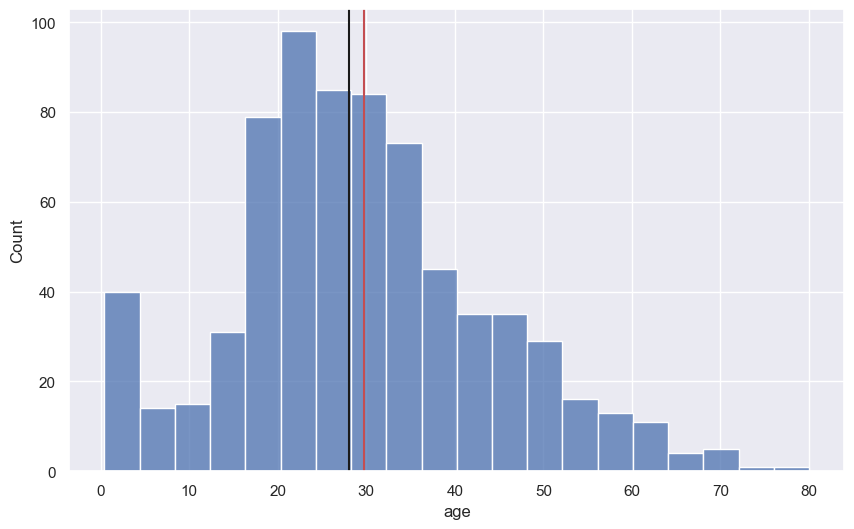

In [839]:
# show 'age' distribution with mean, median and standard deviation

print(f'Age stats: \n{df.age.describe().iloc[[1, 2, 5]]}')

sns.histplot(df.age)
plt.axvline(df.age.mean(), color='r', ymin=0, ymax=1)
plt.axvline(df.age.median(), color='k', ymin=0, ymax=1)
plt.show()

In [840]:
# fill in missing values in 'age' variable

age_mean = df['age'].mean()
age_std = df['age'].std()
is_null = df['age'].isnull().sum()
rand_age = np.random.randint(low=(age_mean - age_std*1.5), high=(age_mean + age_std*1.5), size=is_null)

age_copy = df['age'].copy()
age_copy[np.isnan(age_copy)] = rand_age
df['age'] = age_copy
df['age'] = df['age'].astype('float')

In [841]:
# fill in missing values in 'deck' variable

df.loc[df['pclass'] == 1, 'deck'] = 'A' # deck A was reserved for first class

# fill in null values given adjusted relative frequencies for deck

deck_df = pd.DataFrame(df.deck.value_counts(normalize=True)).reset_index().sort_values('deck')
prob_deck = deck_df['proportion'].values[1:] + (deck_df['proportion'].values[0]/6)

deck_copy = df['deck'].copy()
deck_copy[pd.isnull(deck_copy)] = np.random.choice(['B', 'C', 'D', 'E', 'F', 'G'], p=prob_deck)
df['deck'] = deck_copy

In [842]:
# convert 'deck' in dummy variable

df = pd.get_dummies(df, columns=['deck'], dtype='int')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,embark_town,alive,alone,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
0,0,3,1,22.0,1,0,7.2500,S,Third,man,...,Southampton,no,False,0,0,0,0,0,1,0
1,1,1,0,38.0,1,0,71.2833,C,First,woman,...,Cherbourg,yes,False,1,0,0,0,0,0,0
2,1,3,0,26.0,0,0,7.9250,S,Third,woman,...,Southampton,yes,True,0,0,0,0,0,1,0
3,1,1,0,35.0,1,0,53.1000,S,First,woman,...,Southampton,yes,False,1,0,0,0,0,0,0
4,0,3,1,35.0,0,0,8.0500,S,Third,man,...,Southampton,no,True,0,0,0,0,0,1,0


In [843]:
# drop useless columns

df_clean = df.drop(columns=['fare', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone'])
df_clean.head()

,survived,pclass,sex,age,sibsp,parch,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G
0,0,3,1,22.0,1,0,0,0,0,0,0,1,0
1,1,1,0,38.0,1,0,1,0,0,0,0,0,0
2,1,3,0,26.0,0,0,0,0,0,0,0,1,0
3,1,1,0,35.0,1,0,1,0,0,0,0,0,0
4,0,3,1,35.0,0,0,0,0,0,0,0,1,0


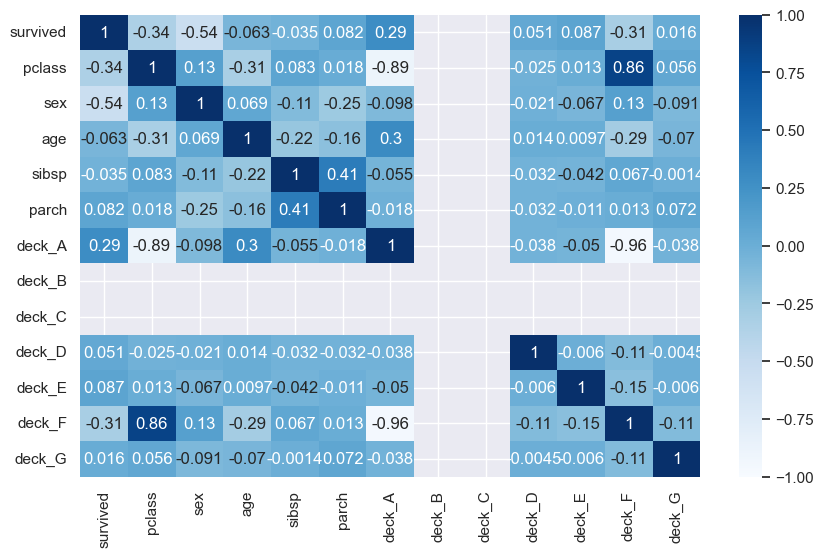

In [844]:
# show correlation coefficients between variables

sns.heatmap(df_clean.corr(), annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.show()

In [845]:
# responce vector y and predictors matrix X

y = df_clean['survived']
X = df_clean[['pclass', 'sex', 'age', 'sibsp', 'parch', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']]

# split data in training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [846]:
# fit a Logistic Regression model to the training data

log_reg = LogisticRegression(max_iter=1000)
log_reg = log_reg.fit(X_train, y_train)

In [847]:
# print intercept and coefficients

predictors = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
coefficients = log_reg.coef_[0]
coef_pred = zip(predictors, coefficients)

print('Intercept:', log_reg.intercept_[0])
print(f'\nCoefficients: \n{pd.Series(coef_pred)}')

Intercept: 4.3818433846091445

Coefficients: 
0     (pclass, -0.896922856111413)
1       (sex, -2.7270026185045957)
2     (age, -0.027579239085237565)
3     (sibsp, -0.4547228859568737)
4     (parch, 0.05915500312515808)
5                    (deck_C, 0.0)
6     (deck_D, 0.7358431901691657)
7     (deck_E, 0.7456842847683207)
8    (deck_F, -0.3391729760372015)
9    (deck_G, -0.5482177996982113)
dtype: object


In [848]:
# predict target values from X_train

pred_train = log_reg.predict(X_train)

In [849]:
# performance metrics of training model

accuracy = metrics.accuracy_score(y_train, pred_train)
precision = metrics.precision_score(y_train, pred_train)
recall = metrics.recall_score(y_train, pred_train)
f_1 = metrics.f1_score(y_train, pred_train)

print('Performance Metrics of Training Model:\n')
print(f'Accuracy pct: {round(accuracy*100, 2)}%')
print('-'*30)
print(f'Precision pct: {round(precision*100, 2)}%')
print('-'*30)
print(f'Recall pct: {round(recall*100, 2)}%')
print('-'*30)
print(f'F1 pct: {round(f_1*100, 2)}%')

Performance Metrics of Training Model:

Accuracy pct: 80.74%
------------------------------
Precision pct: 76.04%
------------------------------
Recall pct: 70.82%
------------------------------
F1 pct: 73.33%


True Negative: 338
False Positive: 52
False Negative: 68
True positive: 165


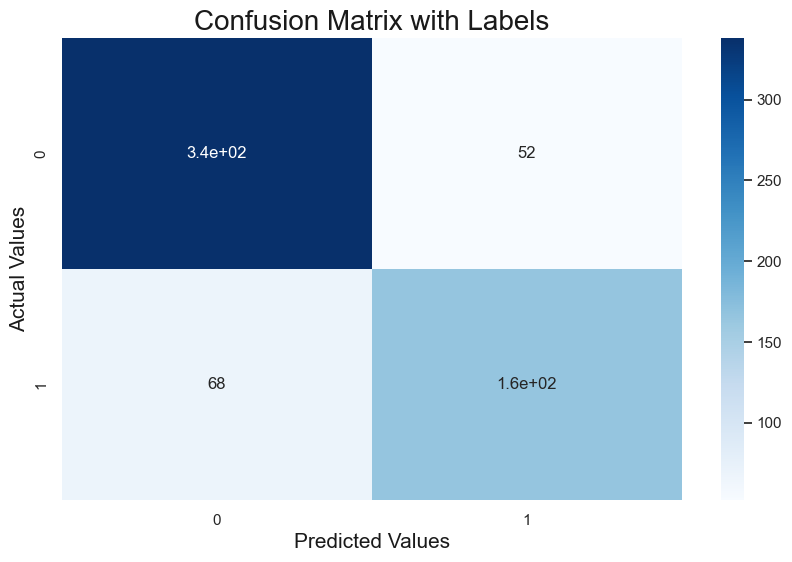

In [850]:
# confusion matrix

cm = metrics.confusion_matrix(y_train, pred_train)
print('True Negative:', cm[0, 0])
print('False Positive:', cm[0, 1])
print('False Negative:', cm[1, 0])
print('True positive:', cm[1, 1])

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix with Labels', {'fontsize':'20', 'color':'k'})
ax.set_xlabel('Predicted Values', {'fontsize':'15', 'color':'k'})
ax.set_ylabel('Actual Values', {'fontsize':'15', 'color':'k'})
ax.set_xticklabels(['0','1'])
ax.set_yticklabels(['0','1'])
plt.show()

In [851]:
# predict target values from X_test

y_pred = log_reg.predict(X_test)

In [852]:
# test evaluation metrics

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_precision = metrics.precision_score(y_test, y_pred)
test_recall = metrics.recall_score(y_test, y_pred)
test_f_1 = metrics.f1_score(y_test, y_pred)

print('Test Evaluation Metrics:\n')
print(f'Test Accuracy pct: {round(test_accuracy*100, 2)}%')
print('-'*30)
print(f'Test Precision pct: {round(test_precision*100, 2)}%')
print('-'*30)
print(f'Test Recall pct: {round(test_recall*100, 2)}%')
print('-'*30)
print(f'Test F1 pct: {round(test_f_1*100, 2)}%')

Test Evaluation Metrics:

Test Accuracy pct: 78.73%
------------------------------
Test Precision pct: 80.23%
------------------------------
Test Recall pct: 63.3%
------------------------------
Test F1 pct: 70.77%


True Negative: 142
False Positive: 17
False Negative: 40
True positive: 69


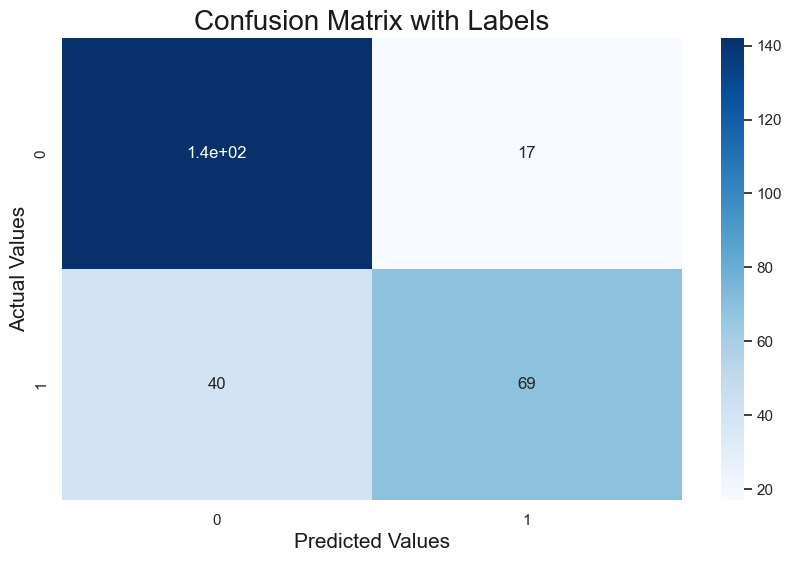

In [853]:
# test confusion matrix

test_cm = metrics.confusion_matrix(y_test, y_pred)
print('True Negative:', test_cm[0, 0])
print('False Positive:', test_cm[0, 1])
print('False Negative:', test_cm[1, 0])
print('True positive:', test_cm[1, 1])

ax = sns.heatmap(test_cm, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix with Labels', {'fontsize':'20', 'color':'k'})
ax.set_xlabel('Predicted Values', {'fontsize':'15', 'color':'k'})
ax.set_ylabel('Actual Values', {'fontsize':'15', 'color':'k'})
ax.set_xticklabels(['0','1'])
ax.set_yticklabels(['0','1'])
plt.show()

In [854]:
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]

In [855]:
# calculate the false and the true positive ratio (fpr and tpr) for all thresholds of the classification

probs = log_reg.predict_proba(X_test)
preds = probs[:,1] # probability estimates of the positive class
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

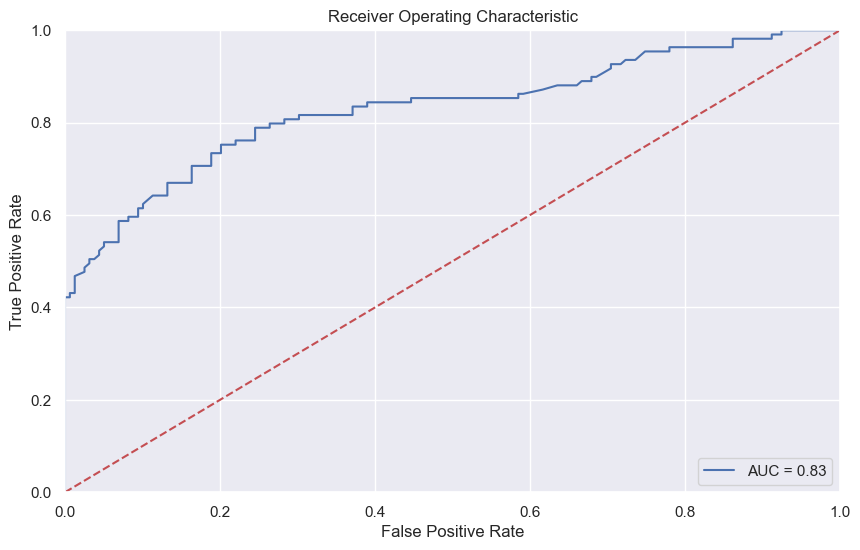

In [856]:
# plot the Receiver Operating Characteristic (ROC) curve and print the (Area Under Curve) AUC

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [857]:
# calculate average accuracy with k-fold cross validation

log_reg = log_reg.fit(X, y)
k = 10
scores = cross_val_score(log_reg, X, y, cv=k, scoring='accuracy')
mean_accuracy = scores.mean()
print(f'Mean accuracy with k-fold cross validation (k={k}): {round(mean_accuracy*100, 2)}%')
print('-'*30)
print(f'Train accuracy pct with train_test_split function: {round(accuracy*100, 2)}%')
print('-'*30)
print(f'Test accuracy pct with train_test_split function: {round(test_accuracy*100, 2)}%')

Mean accuracy with k-fold cross validation (k=10): 78.9%
------------------------------
Train accuracy pct with train_test_split function: 80.74%
------------------------------
Test accuracy pct with train_test_split function: 78.73%
